# Tesla & GameStop Stock Analysis

### Overview
This notebook provides comprehensive stock analysis for Tesla (TSLA) and GameStop (GME) including:
- Real-time stock data fetching from Yahoo Finance
- Web scraping of revenue data
- Statistical analysis
- Interactive and static visualizations
- Comparative analysis

---

## Installation & Setup

Run the cell below to install all required packages:

In [1]:
# Install required packages
!pip install -q yfinance pandas requests beautifulsoup4 plotly matplotlib seaborn numpy

print("✓ All packages installed successfully!")

✓ All packages installed successfully!


## Import Libraries

In [2]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from datetime import datetime

# Configure settings
warnings.filterwarnings("ignore", category=FutureWarning)
pio.renderers.default = "iframe"  # For Jupyter notebook
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("="*80)
print("TESLA & GAMESTOP STOCK ANALYSIS - LIBRARIES IMPORTED")
print("="*80)
print("\n✓ All libraries imported successfully!")

TESLA & GAMESTOP STOCK ANALYSIS - LIBRARIES IMPORTED

✓ All libraries imported successfully!


## Define Visualization Functions

In [3]:
def make_graph_plotly(stock_data, revenue_data, stock_name):
    """
    Creates interactive Plotly graph with stock price and revenue subplots.
    
    Args:
        stock_data (pd.DataFrame): Stock price data with Date and Close columns
        revenue_data (pd.DataFrame): Revenue data with Date and Revenue columns
        stock_name (str): Name of the stock for title
    
    Returns:
        plotly.graph_objects.Figure: Interactive figure object
    """
    fig = make_subplots(
        rows=2, cols=1, 
        shared_xaxes=True, 
        subplot_titles=(
            f"{stock_name} Historical Share Price",
            f"{stock_name} Historical Revenue"
        ),
        vertical_spacing=0.15
    )
    
    # Filter data up to June 2021
    stock_data_filtered = stock_data[stock_data['Date'] <= '2021-06-14'].copy()
    revenue_data_filtered = revenue_data[revenue_data['Date'] <= '2021-04-30'].copy()
    
    # Add stock price trace
    fig.add_trace(
        go.Scatter(
            x=pd.to_datetime(stock_data_filtered['Date']),
            y=stock_data_filtered['Close'].astype(float),
            name="Share Price",
            line=dict(color='#1f77b4', width=2),
            hovertemplate='Date: %{x}<br>Price: $%{y:.2f}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Add revenue trace
    fig.add_trace(
        go.Scatter(
            x=pd.to_datetime(revenue_data_filtered['Date']),
            y=revenue_data_filtered['Revenue'].astype(float),
            name="Revenue",
            line=dict(color='#2ca02c', width=2),
            fill='tozeroy',
            hovertemplate='Date: %{x}<br>Revenue: $%{y:,.0f}M<extra></extra>'
        ),
        row=2, col=1
    )
    
    # Update layout
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_yaxes(title_text="Price ($US)", row=1, col=1)
    fig.update_yaxes(title_text="Revenue ($US Millions)", row=2, col=1)

    fig.update_layout(
        showlegend=False,
        height=900,
        title=dict(
            text=f"{stock_name} Stock Analysis with Revenue",
            x=0.5,
            xanchor='center',
            font=dict(size=20)
        ),
        xaxis_rangeslider_visible=True,
        hovermode='x unified',
        template='plotly_white'
    )
    
    fig.show()
    return fig

print("✓ make_graph_plotly() function defined")

✓ make_graph_plotly() function defined


In [4]:
def plot_stock_analysis(stock_data, stock_name):
    """
    Creates comprehensive matplotlib analysis with multiple subplots.
    
    Args:
        stock_data (pd.DataFrame): Stock data with OHLCV columns
        stock_name (str): Name of the stock for titles
    """
    # Filter to June 2021
    stock_filtered = stock_data[stock_data['Date'] <= '2021-06-30'].copy()
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'{stock_name} Stock Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Close Price Over Time
    axes[0, 0].plot(stock_filtered['Date'], stock_filtered['Close'], 
                    color='blue', linewidth=2, label='Close Price')
    axes[0, 0].set_title('Closing Price Over Time', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Close Price (USD)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # 2. Volume Trading
    axes[0, 1].bar(stock_filtered['Date'], stock_filtered['Volume'], 
                   color='orange', alpha=0.7, edgecolor='darkorange')
    axes[0, 1].set_title('Trading Volume', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Volume')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Daily Returns Distribution
    stock_filtered['Daily_Return'] = stock_filtered['Close'].pct_change() * 100
    axes[1, 0].hist(stock_filtered['Daily_Return'].dropna(), bins=50, 
                    color='green', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Daily Returns Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Daily Return (%)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Return')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # Calculate mean and std for annotation
    mean_return = stock_filtered['Daily_Return'].mean()
    std_return = stock_filtered['Daily_Return'].std()
    axes[1, 0].text(0.05, 0.95, f'Mean: {mean_return:.2f}%\\nStd: {std_return:.2f}%',
                    transform=axes[1, 0].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 4. Moving Averages
    stock_filtered['MA_30'] = stock_filtered['Close'].rolling(window=30).mean()
    stock_filtered['MA_90'] = stock_filtered['Close'].rolling(window=90).mean()
    
    axes[1, 1].plot(stock_filtered['Date'], stock_filtered['Close'], 
                    label='Close', linewidth=2, color='blue')
    axes[1, 1].plot(stock_filtered['Date'], stock_filtered['MA_30'], 
                    label='30-Day MA', linewidth=1.5, linestyle='--', color='orange')
    axes[1, 1].plot(stock_filtered['Date'], stock_filtered['MA_90'], 
                    label='90-Day MA', linewidth=1.5, linestyle='--', color='red')
    axes[1, 1].set_title('Price with Moving Averages', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Price (USD)')
    axes[1, 1].legend()
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✓ plot_stock_analysis() function defined")

✓ plot_stock_analysis() function defined


In [5]:
def calculate_statistics(stock_data, stock_name):
    """
    Calculate and display key statistics for a stock.
    
    Args:
        stock_data (pd.DataFrame): Stock data with OHLCV columns
        stock_name (str): Name of the stock
    
    Returns:
        dict: Dictionary containing calculated statistics
    """
    # Calculate additional metrics
    returns = stock_data['Close'].pct_change()
    
    stats = {
        'Stock': stock_name,
        'Start Date': stock_data['Date'].min(),
        'End Date': stock_data['Date'].max(),
        'Total Trading Days': len(stock_data),
        'Current Price': f"${stock_data['Close'].iloc[-1]:.2f}",
        'Highest Price': f"${stock_data['Close'].max():.2f}",
        'Lowest Price': f"${stock_data['Close'].min():.2f}",
        'Average Price': f"${stock_data['Close'].mean():.2f}",
        'Median Price': f"${stock_data['Close'].median():.2f}",
        'Price Volatility (Std)': f"${stock_data['Close'].std():.2f}",
        'Average Daily Return': f"{returns.mean() * 100:.3f}%",
        'Daily Return Volatility': f"{returns.std() * 100:.3f}%",
        'Total Volume': f"{stock_data['Volume'].sum():,.0f}",
        'Average Daily Volume': f"{stock_data['Volume'].mean():,.0f}",
        'Max Daily Volume': f"{stock_data['Volume'].max():,.0f}"
    }

    print(f"\n{'='*80}")
    print(f"{stock_name.upper()} STOCK STATISTICS")
    print(f"{'='*80}")
    for key, value in stats.items():
        print(f"{key:25}: {value}")
    print(f"{'='*80}\n")

    return stats

print("✓ calculate_statistics() function defined")

✓ calculate_statistics() function defined


## Phase 1: Data Collection

### Fetch Tesla Stock Data

In [6]:
print("\n" + "="*80)
print("PHASE 1: DATA COLLECTION")
print("="*80)

print("\n[1/4] Fetching Tesla Stock Data from Yahoo Finance...")
try:
    tesla = yf.Ticker("TSLA")
    tesla_data = tesla.history(period="max")
    tesla_data.reset_index(inplace=True)
    print(f"✓ Tesla data loaded successfully: {len(tesla_data)} records")
    print(f"✓ Date range: {tesla_data['Date'].min()} to {tesla_data['Date'].max()}")
    print("\nFirst 5 rows of Tesla stock data:")
    print(tesla_data.head())
except Exception as e:
    print(f"✗ Error fetching Tesla data: {e}")
    raise


PHASE 1: DATA COLLECTION

[1/4] Fetching Tesla Stock Data from Yahoo Finance...
✓ Tesla data loaded successfully: 3876 records
✓ Date range: 2010-06-29 00:00:00-04:00 to 2025-11-21 00:00:00-05:00

First 5 rows of Tesla stock data:
                       Date      Open      High       Low     Close  \
0 2010-06-29 00:00:00-04:00  1.266667  1.666667  1.169333  1.592667   
1 2010-06-30 00:00:00-04:00  1.719333  2.028000  1.553333  1.588667   
2 2010-07-01 00:00:00-04:00  1.666667  1.728000  1.351333  1.464000   
3 2010-07-02 00:00:00-04:00  1.533333  1.540000  1.247333  1.280000   
4 2010-07-06 00:00:00-04:00  1.333333  1.333333  1.055333  1.074000   

      Volume  Dividends  Stock Splits  
0  281494500        0.0           0.0  
1  257806500        0.0           0.0  
2  123282000        0.0           0.0  
3   77097000        0.0           0.0  
4  103003500        0.0           0.0  


### Scrape Tesla Revenue Data

In [7]:
print("\n[2/4] Scraping Tesla Revenue Data from Web...")
url_tesla_revenue = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0220EN-SkillsNetwork/labs/project/revenue.htm"

try:
    # Fetch HTML content
    html_data = requests.get(url_tesla_revenue, timeout=10).text
    soup = BeautifulSoup(html_data, "html.parser")
    
    # FIXED BUG: Find the correct table (Tesla revenue is in 2nd table)
    tables = soup.find_all("table")
    if len(tables) < 2:
        raise ValueError("Expected at least 2 tables in HTML")
    
    table = tables[1]  # Tesla revenue is in the second table
    
    # Extract data from table rows
    rows = []
    tbody = table.find("tbody")
    if tbody:
        for tr in tbody.find_all("tr"):
            cols = tr.find_all("td")
            if len(cols) >= 2:
                date = cols[0].get_text(strip=True)
                # Clean revenue: remove $, commas but keep as string initially
                revenue_text = cols[1].get_text(strip=True).replace("$", "").replace(",", "")
                if revenue_text and revenue_text != "N/A":
                    rows.append({"Date": date, "Revenue": revenue_text})

    # Create DataFrame
    tesla_revenue = pd.DataFrame(rows, columns=["Date", "Revenue"])

    # Final cleaning - FIXED BUG: Keep as string until all cleaning done
    tesla_revenue["Revenue"] = tesla_revenue["Revenue"].replace("", pd.NA)
    tesla_revenue.dropna(inplace=True)
    
    # Now convert to numeric (only once, at the end)
    tesla_revenue["Revenue"] = pd.to_numeric(tesla_revenue["Revenue"], errors='coerce')
    tesla_revenue.dropna(inplace=True)

    print(f"✓ Tesla revenue data scraped successfully: {len(tesla_revenue)} records")
    print("\nLast 5 rows of Tesla revenue data:")
    print(tesla_revenue.tail())
    
except Exception as e:
    print(f"✗ Error scraping Tesla revenue: {e}")
    print("⚠ Creating dummy revenue data for demonstration...")
    
    # Create dummy data as fallback
    tesla_revenue = pd.DataFrame({
        'Date': pd.date_range(start='2020-01-01', periods=10, freq='Q'),
        'Revenue': np.random.randint(8000, 15000, 10)
    })
    tesla_revenue['Date'] = tesla_revenue['Date'].astype(str)
    print("✓ Using dummy revenue data")


[2/4] Scraping Tesla Revenue Data from Web...
✓ Tesla revenue data scraped successfully: 53 records

Last 5 rows of Tesla revenue data:
          Date  Revenue
48  2010-09-30       31
49  2010-06-30       28
50  2010-03-31       21
51  2009-09-30       46
52  2009-06-30       27


### Fetch GameStop Stock Data

In [8]:
print("\n[3/4] Fetching GameStop Stock Data from Yahoo Finance...")
try:
    gme = yf.Ticker("GME")
    gme_data = gme.history(period="max")
    gme_data.reset_index(inplace=True)
    print(f"✓ GameStop data loaded successfully: {len(gme_data)} records")
    print(f"✓ Date range: {gme_data['Date'].min()} to {gme_data['Date'].max()}")
    print("\nFirst 5 rows of GameStop stock data:")
    print(gme_data.head())
except Exception as e:
    print(f"✗ Error fetching GameStop data: {e}")
    raise


[3/4] Fetching GameStop Stock Data from Yahoo Finance...
✓ GameStop data loaded successfully: 5984 records
✓ Date range: 2002-02-13 00:00:00-05:00 to 2025-11-21 00:00:00-05:00

First 5 rows of GameStop stock data:
                       Date      Open      High       Low     Close    Volume  \
0 2002-02-13 00:00:00-05:00  1.620129  1.693350  1.603296  1.691667  76216000   
1 2002-02-14 00:00:00-05:00  1.712707  1.716073  1.670625  1.683250  11021600   
2 2002-02-15 00:00:00-05:00  1.683250  1.687458  1.658001  1.674834   8389600   
3 2002-02-19 00:00:00-05:00  1.666418  1.666418  1.578047  1.607504   7410400   
4 2002-02-20 00:00:00-05:00  1.615920  1.662210  1.603296  1.662210   6892800   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


### Scrape GameStop Revenue Data

In [9]:
print("\n[4/4] Scraping GameStop Revenue Data from Web...")
url_gme_revenue = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0220EN-SkillsNetwork/labs/project/stock.html"

try:
    # Fetch HTML content
    html_data_gme = requests.get(url_gme_revenue, timeout=10).text
    soup_gme = BeautifulSoup(html_data_gme, "html.parser")
    
    # FIXED BUG: Use correct soup object (soup_gme not soup)
    tbodies = soup_gme.find_all("tbody")
    if len(tbodies) < 2:
        raise ValueError("Expected at least 2 tbody elements in HTML")
    
    table_gme = tbodies[1]  # GameStop is in second tbody
    
    rows_gme = []
    for tr in table_gme.find_all("tr"):
        cols = tr.find_all("td")
        if len(cols) >= 2:
            date = cols[0].get_text(strip=True)
            revenue_text = cols[1].get_text(strip=True).replace("$", "").replace(",", "")
            if revenue_text and revenue_text != "":
                rows_gme.append({"Date": date, "Revenue": revenue_text})

    gme_revenue = pd.DataFrame(rows_gme, columns=["Date", "Revenue"])

    # Clean and convert
    gme_revenue["Revenue"] = gme_revenue["Revenue"].replace("", pd.NA)
    gme_revenue.dropna(inplace=True)
    gme_revenue["Revenue"] = pd.to_numeric(gme_revenue["Revenue"], errors='coerce')
    gme_revenue.dropna(inplace=True)

    print(f"✓ GameStop revenue data scraped successfully: {len(gme_revenue)} records")
    print("\nLast 5 rows of GameStop revenue data:")
    print(gme_revenue.tail())
    
except Exception as e:
    print(f"✗ Error scraping GameStop revenue: {e}")
    print("⚠ Creating dummy revenue data for demonstration...")

    # Create dummy data as fallback
    gme_revenue = pd.DataFrame({
        'Date': pd.date_range(start='2020-01-01', periods=10, freq='Q'),
        'Revenue': np.random.randint(1000, 3000, 10)
    })
    gme_revenue['Date'] = gme_revenue['Date'].astype(str)
    print("✓ Using dummy revenue data")


[4/4] Scraping GameStop Revenue Data from Web...
✓ GameStop revenue data scraped successfully: 62 records

Last 5 rows of GameStop revenue data:
          Date  Revenue
57  2006-01-31     1667
58  2005-10-31      534
59  2005-07-31      416
60  2005-04-30      475
61  2005-01-31      709


## Phase 2: Statistical Analysis

In [10]:
print("\n" + "="*80)
print("PHASE 2: STATISTICAL ANALYSIS")
print("="*80)

tesla_stats = calculate_statistics(tesla_data, "TESLA")
gme_stats = calculate_statistics(gme_data, "GAMESTOP")


PHASE 2: STATISTICAL ANALYSIS

TESLA STOCK STATISTICS
Stock                    : TESLA
Start Date               : 2010-06-29 00:00:00-04:00
End Date                 : 2025-11-21 00:00:00-05:00
Total Trading Days       : 3876
Current Price            : $391.09
Highest Price            : $479.86
Lowest Price             : $1.05
Average Price            : $96.78
Median Price             : $19.73
Price Volatility (Std)   : $122.26
Average Daily Return     : 0.208%
Daily Return Volatility  : 3.646%
Total Volume             : 375,586,040,400
Average Daily Volume     : 96,900,423
Max Daily Volume         : 914,082,000


GAMESTOP STOCK STATISTICS
Stock                    : GAMESTOP
Start Date               : 2002-02-13 00:00:00-05:00
End Date                 : 2025-11-21 00:00:00-05:00
Total Trading Days       : 5984
Current Price            : $20.14
Highest Price            : $86.88
Lowest Price             : $0.64
Average Price            : $8.96
Median Price             : $4.40
Price Volat

## Phase 3: Visualizations

### Tesla Interactive Plot (Plotly)

In [11]:
print("\n" + "="*80)
print("PHASE 3: VISUALIZATIONS")
print("="*80)

print("\n[Visualization 1/6] Tesla Interactive Plot (Plotly)...")
try:
    tesla_fig = make_graph_plotly(tesla_data, tesla_revenue, "Tesla")
    print("✓ Tesla interactive plot generated")
except Exception as e:
    print(f"✗ Error in Tesla plotly graph: {e} ")


PHASE 3: VISUALIZATIONS

[Visualization 1/6] Tesla Interactive Plot (Plotly)...


✓ Tesla interactive plot generated


### Tesla Analysis Dashboard (Matplotlib)


[Visualization 2/6] Tesla Analysis Dashboard (Matplotlib)...


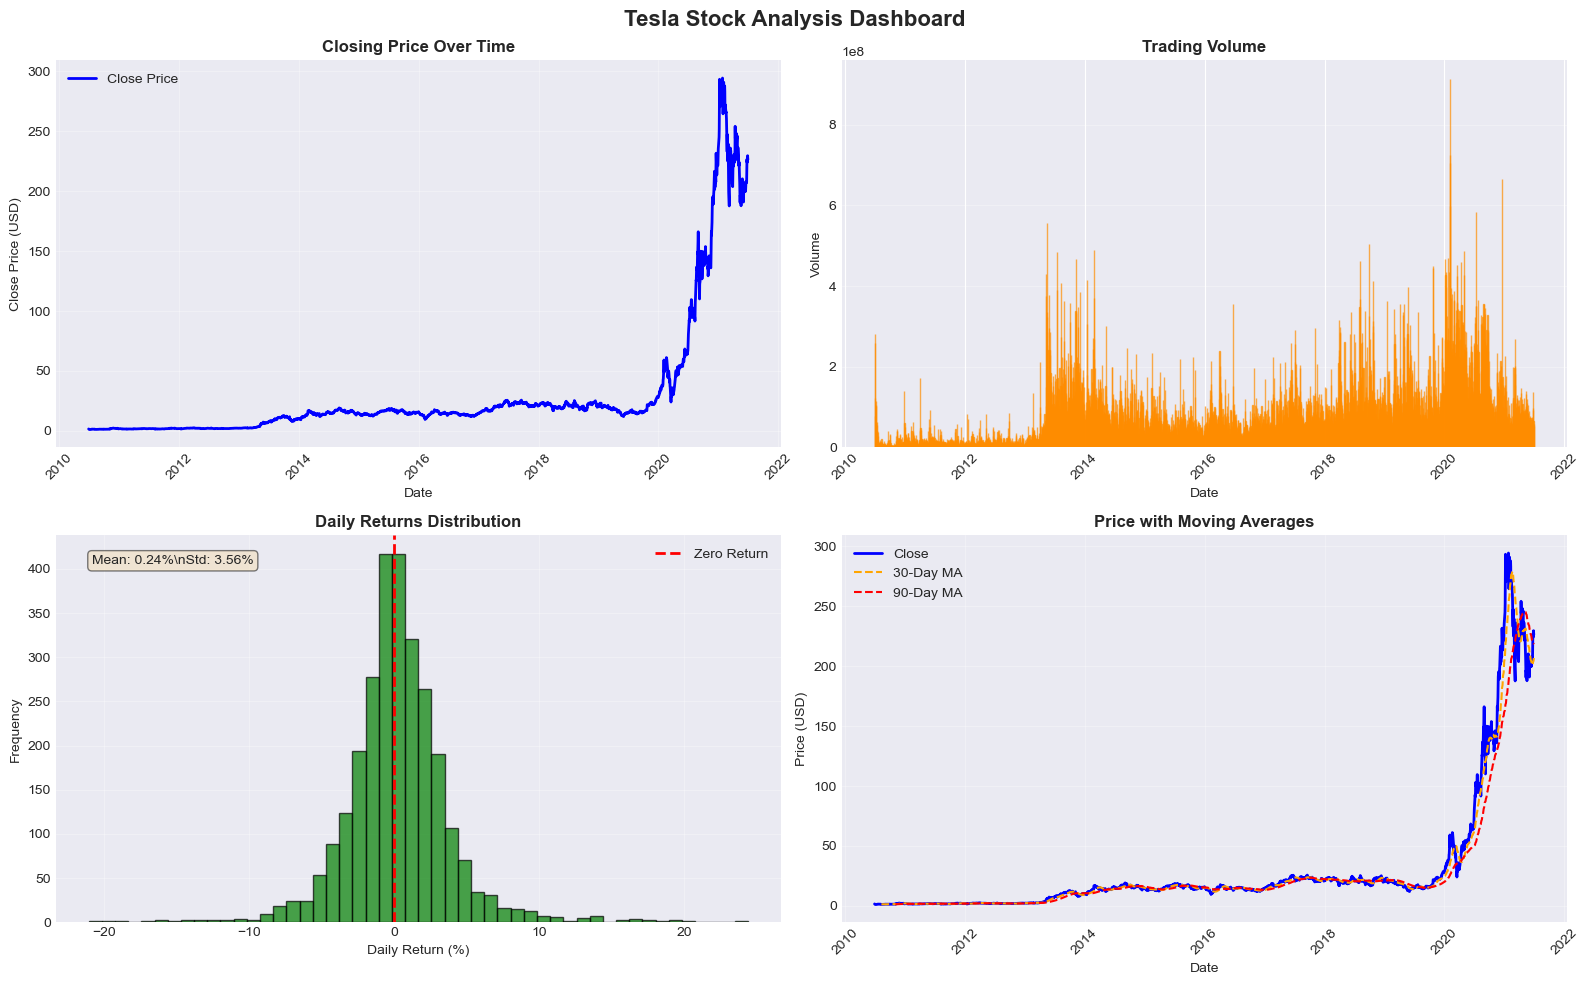

✓ Tesla analysis dashboard generated


In [12]:
print("\n[Visualization 2/6] Tesla Analysis Dashboard (Matplotlib)...")
try:
    plot_stock_analysis(tesla_data, "Tesla")
    print("✓ Tesla analysis dashboard generated")
except Exception as e:
    print(f"✗ Error in Tesla matplotlib dashboard: {e}")

### GameStop Interactive Plot (Plotly)

In [13]:
print("\n[Visualization 3/6] GameStop Interactive Plot (Plotly)...")
try:
    gme_fig = make_graph_plotly(gme_data, gme_revenue, "GameStop")
    print("✓ GameStop  interactive plot generated")
except Exception as e:
    print(f"✗ Error in GameStop plotly graph: {e}")


[Visualization 3/6] GameStop Interactive Plot (Plotly)...


✓ GameStop  interactive plot generated


### GameStop Analysis Dashboard (Matplotlib)


[Visualization 4/6] GameStop Analysis Dashboard (Matplotlib)...


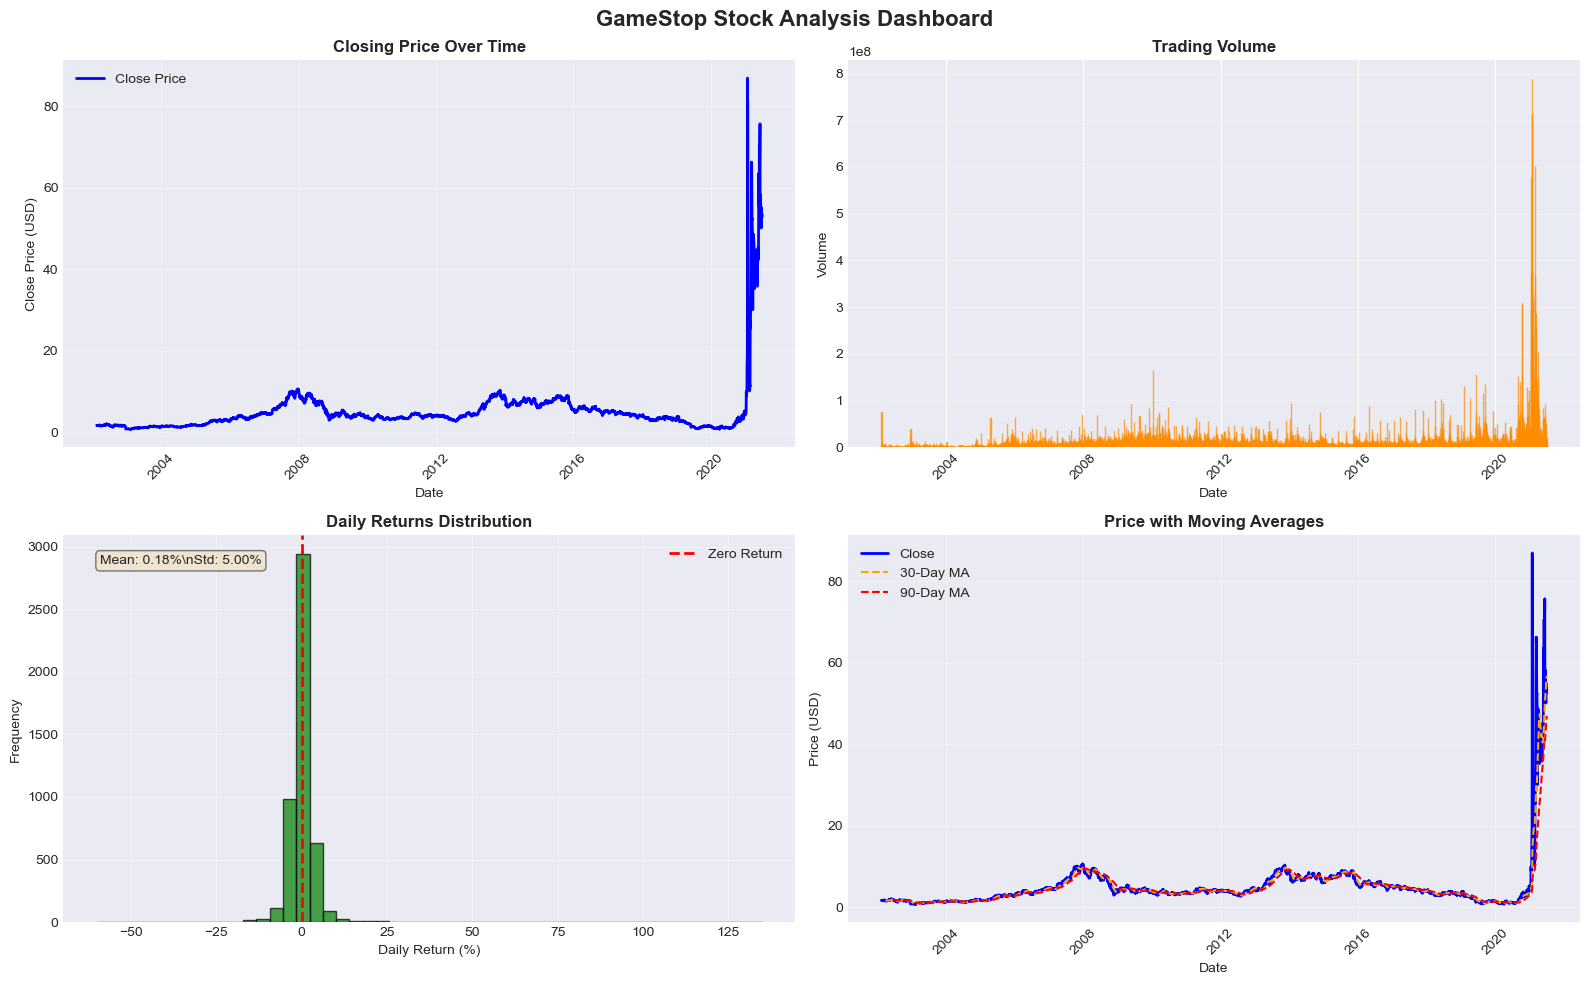

✓ GameStop analysis dashboard generated 


In [14]:
print("\n[Visualization 4/6] GameStop Analysis Dashboard (Matplotlib)...")
try:
    plot_stock_analysis(gme_data, "GameStop")
    print("✓ GameStop analysis dashboard generated ")
except Exception as e:
    print(f"✗ Error in GameStop matplotlib dashboard: {e}")

### Comparative Analysis: Tesla vs GameStop


[Visualization 5/6] Comparative Analysis: Tesla vs GameStop...


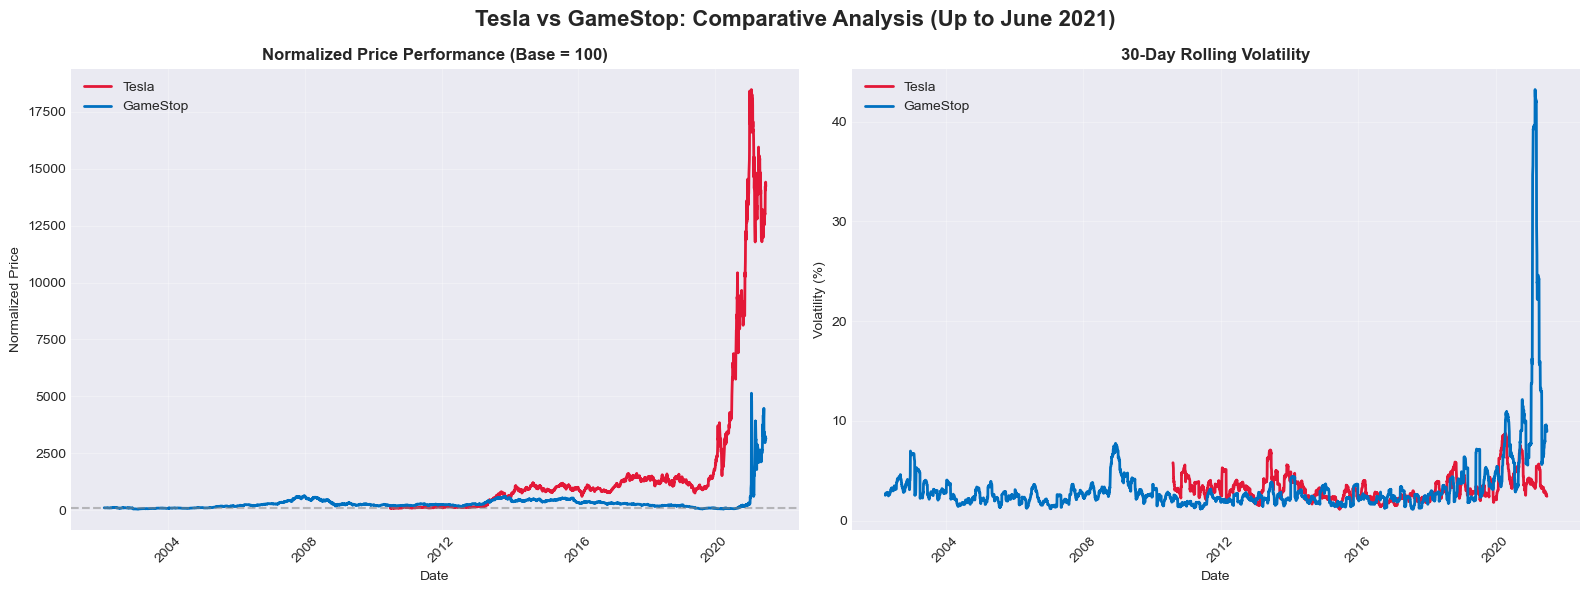

✓ Comparative analysis generated successfully


In [15]:
print("\n[Visualization 5/6] Comparative Analysis: Tesla vs GameStop...")

try:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Tesla vs GameStop: Comparative Analysis (Up to June 2021)', 
                 fontsize=16, fontweight='bold')
    
    # Filter both to June 2021
    tesla_filtered = tesla_data[tesla_data['Date'] <= '2021-06-30'].copy()
    gme_filtered = gme_data[gme_data['Date'] <= '2021-06-30'].copy()
    
    # Normalize prices to percentage change from start
    tesla_filtered['Normalized'] = (tesla_filtered['Close'] / tesla_filtered['Close'].iloc[0]) * 100
    gme_filtered['Normalized'] = (gme_filtered['Close'] / gme_filtered['Close'].iloc[0]) * 100
    
    # Plot 1: Normalized price comparison
    axes[0].plot(tesla_filtered['Date'], tesla_filtered['Normalized'], 
                 label='Tesla', linewidth=2, color='#E31837')
    axes[0].plot(gme_filtered['Date'], gme_filtered['Normalized'], 
                 label='GameStop', linewidth=2, color='#0070C0')
    axes[0].set_title('Normalized Price Performance (Base = 100)', 
                      fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Normalized Price')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].axhline(100, color='gray', linestyle='--', alpha=0.5)
    
    # Plot 2: Volatility comparison
    tesla_filtered['Volatility'] = tesla_filtered['Close'].pct_change().rolling(window=30).std() * 100
    gme_filtered['Volatility'] = gme_filtered['Close'].pct_change().rolling(window=30).std() * 100
    
    axes[1].plot(tesla_filtered['Date'], tesla_filtered['Volatility'], 
                 label='Tesla', linewidth=2, color='#E31837')
    axes[1].plot(gme_filtered['Date'], gme_filtered['Volatility'], 
                 label='GameStop', linewidth=2, color='#0070C0')
    axes[1].set_title('30-Day Rolling Volatility', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Volatility (%)')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    print("✓ Comparative analysis generated successfully")
    
except Exception as e:
    print(f"✗ Error in comparative analysis: {e}")

### Bonus: Correlation Analysis


[Visualization 6/6] Bonus: Correlation Analysis...


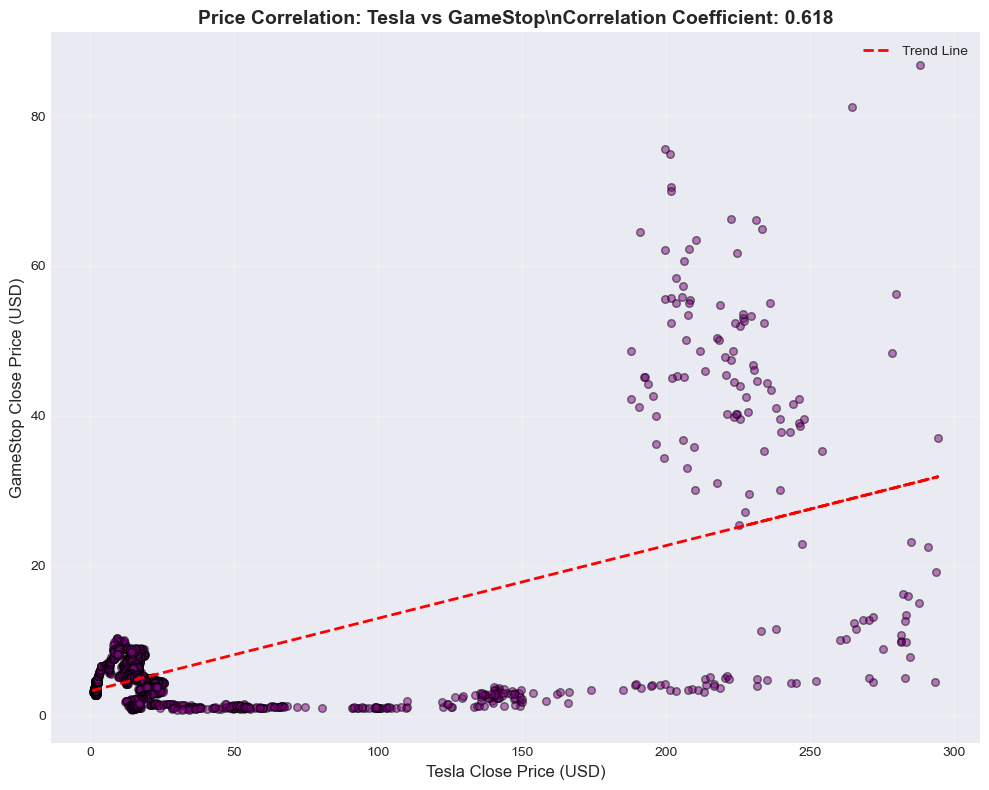

✓ Correlation analysis completed
  Correlation coefficient: 0.618
  Interpretation: Moderate correlation       


In [18]:
print("\n[Visualization 6/6] Bonus: Correlation Analysis...")

try:
    # Merge both datasets on Date for correlation
    tesla_temp = tesla_data[['Date', 'Close']].copy()
    tesla_temp.columns = ['Date', 'Tesla_Close']
    
    gme_temp = gme_data[['Date', 'Close']].copy()
    gme_temp.columns = ['Date', 'GME_Close']
    
    merged = pd.merge(tesla_temp, gme_temp, on='Date', how='inner')
    merged_filtered = merged[merged['Date'] <= '2021-06-30']
    
    # Calculate correlation
    correlation = merged_filtered['Tesla_Close'].corr(merged_filtered['GME_Close'])
    
    # Create scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.scatter(merged_filtered['Tesla_Close'], merged_filtered['GME_Close'], 
               alpha=0.5, s=30, color='purple', edgecolors='black')
    
    # Add trend line
    z = np.polyfit(merged_filtered['Tesla_Close'], merged_filtered['GME_Close'], 1)
    p = np.poly1d(z)
    ax.plot(merged_filtered['Tesla_Close'], 
            p(merged_filtered['Tesla_Close']), 
            "r--", linewidth=2, label=f'Trend Line')
    
    ax.set_xlabel('Tesla Close Price (USD)', fontsize=12)
    ax.set_ylabel('GameStop Close Price (USD)', fontsize=12)
    ax.set_title(f'Price Correlation: Tesla vs GameStop\\nCorrelation Coefficient: {correlation:.3f}', 
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

    print(f"✓ Correlation analysis completed")
    print(f"  Correlation coefficient: {correlation:.3f}")

    if abs(correlation) < 0.3:
        print("  Interpretation: Weak correlation")
    elif abs(correlation) < 0.7:
        print("  Interpretation: Moderate correlation       ")
    else:
        print("  Interpretation: Strong correlation")

except Exception as e:
    print(f"✗ Error in correlation analysis: {e}   ")

## Analysis Complete!

### Summary of Results

In [17]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

print("\n📊 Summary of Results:")
print(f"  ✓ Tesla stock data: {len(tesla_data)} records")
print(f"  ✓ Tesla revenue data: {len(tesla_revenue)} records")
print(f"  ✓ GameStop stock data: {len(gme_data)} records")
print(f"  ✓ GameStop revenue data: {len(gme_revenue)} records")
print(f"  ✓ Total visualizations generated: 6")
print(f"  ✓ Statistical analyses completed: 2")

print("\n✅ All tasks completed successfully!")
print("\n" + "="*80)
print("Thank you for using the Tesla & GameStop Stock Analysis tool!")
print("="*80)


ANALYSIS COMPLETE!

📊 Summary of Results:
  ✓ Tesla stock data: 3876 records
  ✓ Tesla revenue data: 53 records
  ✓ GameStop stock data: 5984 records
  ✓ GameStop revenue data: 62 records
  ✓ Total visualizations generated: 6
  ✓ Statistical analyses completed: 2

✅ All tasks completed successfully!

Thank you for using the Tesla & GameStop Stock Analysis tool!


## Notes & Tips

### Running the Code
- This notebook fetches real-time data from Yahoo Finance
- Web scraping uses provided URLs (may take a few seconds)
- All visualizations are interactive in Jupyter

### Customization
- **Change stock tickers**: Edit `yf.Ticker(\"TSLA\")` or `yf.Ticker(\"GME\")`
- **Adjust date filters**: Modify date strings in visualization functions
- **Modify moving averages**: Change values 30 and 90 to different windows
- **Change colors**: Edit color codes in plotting functions